In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/mnt/libraries/Codes/EURECOM/MALIS_project


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchaudio
from pathlib import Path
import numpy as np
import matplotlib

from tqdm.notebook import tqdm

from src.data.audio import onf_transform
from src.data.datasets import MAPSDataset
from src.data.audio import MadmomSpectrogram
from src.data.data_modules import MAPSDataModule
from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_multilabel_classification
from src.eval import compute_frame_metrics

/home/minhduc0711/miniconda3/envs/piano-transcribe/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
# audio_transform = MadmomSpectrogram(hop_length=441*4, sample_rate=16000)
max_steps = 5
dm = MAPSDataModule(batch_size=4,
                    sample_rate=16000,
                    max_steps=max_steps,
                    audio_transform=onf_transform,
                    hop_length=512,
                    lazy_loading=False,
                    debug=False)
dm.setup()

Loading data samples into memory:   0%|          | 0/180 [00:00<?, ?it/s]/home/minhduc0711/miniconda3/envs/piano-transcribe/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/minhduc0711/miniconda3/envs/piano-transcribe/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_lengt

In [15]:
dm.train_ds.max_steps = 1

In [16]:
next(iter(dm.train_dataloader()))["audio"].shape

torch.Size([4, 1, 229])

In [4]:
def unpack_batch(batch):
    batch_size = batch["audio"].shape[0]
    feats = batch["audio"].numpy().reshape(batch_size, -1)
    labels = batch['frames'].numpy()[:,2,:].astype(np.int)
    return feats, labels

In [7]:
log_reg = MultiOutputClassifier(SGDClassifier(loss='log'))
num_iters = 100
for it in tqdm(range(num_iters), desc="Epoch"):
    for i, batch in tqdm(enumerate(dm.train_dataloader()), 
                         total=len(dm.train_dataloader()), 
                         leave=False,
                         desc="Batch"):
        feats, labels = unpack_batch(batch)
        classes = [np.array([0,1]) for i in range(88)] if i == 0 else None
        log_reg.partial_fit(feats, labels, classes=classes)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fca79be01f0>
Traceback (most recent call last):
  File "/home/minhduc0711/miniconda3/envs/piano-transcribe/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/minhduc0711/miniconda3/envs/piano-transcribe/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fca79be01f0>w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)

  File "/home/minhduc0711/miniconda3/envs/piano-transcribe/lib/python3.8/multiprocessing/process.py", line 147, in join
    Traceback (most recent call last):
  File "/home/minhduc0711/miniconda3/envs/piano-transcribe/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
assert self._parent_pid == os.getpid(), 'can only join a child process'Exception ignored in: Exception ignore

In [17]:
# Test with full sequences
sample_metrics = []
for batch in dm.test_dataloader():
    seqs = batch["audio"].numpy().squeeze()
    num_steps, in_feats = seqs.shape
    # zero-pad 
    pad_size = max_steps // 2
    pad = np.zeros((pad_size, in_feats)) 
    seqs = np.vstack((pad, seqs, pad))
    # accumulate windows of size max_steps
    windows = []
    for i in range(seqs.shape[0] - max_steps + 1):
        windows.append(seqs[i: i + max_steps])
    windows = np.array(windows).reshape(num_steps, -1)
    
    y_pred = log_reg.predict(windows).squeeze()
    labels = batch["frames"].numpy().squeeze()
    sample_metrics.append(compute_frame_metrics(y_pred, labels))

torch.Size([1, 12045, 229]) torch.Size([1, 12045, 88])
torch.Size([1, 915, 229]) torch.Size([1, 915, 88])
torch.Size([1, 8568, 229]) torch.Size([1, 8568, 88])
torch.Size([1, 3246, 229]) torch.Size([1, 3246, 88])
torch.Size([1, 3317, 229]) torch.Size([1, 3317, 88])
torch.Size([1, 2904, 229]) torch.Size([1, 2904, 88])
torch.Size([1, 4433, 229]) torch.Size([1, 4433, 88])
torch.Size([1, 12325, 229]) torch.Size([1, 12325, 88])
torch.Size([1, 8641, 229]) torch.Size([1, 8641, 88])
torch.Size([1, 4277, 229]) torch.Size([1, 4277, 88])
torch.Size([1, 3119, 229]) torch.Size([1, 3119, 88])
torch.Size([1, 2704, 229]) torch.Size([1, 2704, 88])
torch.Size([1, 16468, 229]) torch.Size([1, 16468, 88])
torch.Size([1, 16379, 229]) torch.Size([1, 16379, 88])
torch.Size([1, 4964, 229]) torch.Size([1, 4964, 88])
torch.Size([1, 6610, 229]) torch.Size([1, 6610, 88])
torch.Size([1, 9565, 229]) torch.Size([1, 9565, 88])
torch.Size([1, 19827, 229]) torch.Size([1, 19827, 88])
torch.Size([1, 8076, 229]) torch.Size(

In [18]:
from collections import defaultdict

final_metrics = defaultdict(lambda: defaultdict(lambda: "N/A"))
for metric_type in sample_metrics[0].keys():
    for cls_metric in sample_metrics[0][metric_type]:
        vals = [metric[metric_type][cls_metric] for metric in sample_metrics]
        final_metrics[metric_type][cls_metric] = f"{np.mean(vals):.4f} \u00B1 {np.std(vals):.4f}"
final_metrics

defaultdict(<function __main__.<lambda>()>,
            {'frame': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'precision': '0.4705 ± 0.0956',
                          'recall': '0.5790 ± 0.0940',
                          'f1': '0.5088 ± 0.0683'})})

In [22]:
final_metrics["frame"]

defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
            {'precision': '0.4705 ± 0.0956',
             'recall': '0.5790 ± 0.0940',
             'f1': '0.5088 ± 0.0683'})

In [27]:
sample_metrics[0]

{'frame': {'precision': 0.9147727272727273,
  'recall': 0.9147727272727273,
  'f1': 0.9147727272727273}}

In [10]:
svm_clf = MultiOutputClassifier(SGDClassifier(loss='hinge'))
for i_batch,batch in enumerate(train_loader):
    batch_input = torch.reshape(batch['audio'], [4, 5*294])
    batch_output = batch['frames'][:,2,:]
    svm_clf.partial_fit(batch_input.numpy(), batch_output.numpy().astype(np.int), classes=[np.array([0,1]) for i in range(88)])

In [11]:
accuracy = 0
for batch in validate_loader:
    batch_input = torch.reshape(batch['audio'], [batch['audio'].shape[0], 5*294])
    batch_output = batch['frames'][:,2,:]
    batch_pred = svm_clf.predict(batch_input.numpy())
    accuracy += accuracy_score(batch_output.numpy().astype(int).flatten(), batch_pred.flatten())

print('Average accurary: ', accuracy/len(validate_loader))

Average accurary:  0.9019886363636365


In [46]:
import matplotlib.pyplot as plt

def plot(sample_metrics): 
    frames = [i for i in range(len(sample_metrics))]
    precisions = [i['frame']['precision'] for i in sample_metrics]
    recalls = [i['frame']['recall'] for i in sample_metrics]    
    f1 = [i['frame']['f1'] for i in sample_metrics]    
    plt.plot(frames, precisions, 'r', label='precisions')
    plt.plot(frames, recalls, 'b', label='recalls')
    plt.plot(frames, f1, 'g', label='f1')
    plt.legend()
    plt.xlabel('Frames')
    plt.ylabel('Values')
    plt.title('Data evaluation')
    plt.show()

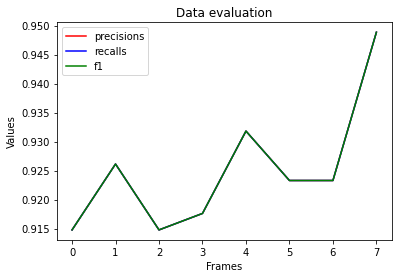

In [47]:
plot(sample_metrics)